# **M5 Forecast Accuracy Research**

This is a continuation of my work on analyzing the sales data of Walmart's TX_1 store (Version 1 found here:https://www.kaggle.com/jimmyliuu/m5-forecast-accuracy-research-version-1). This week, I performed additive decomposition on total sales data. In addition,  I used two forecasting algorithms (ARIMA and SARIMA) to predict TX_1's future total sales based on the June 1st training data.

I followed Jason Brownlee's "How to Decompose Time Series Data into Trend and Seasonality" to perform additive decomposition (found here:https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

I followed Selva Prabhakaran's guide on Time Series Forecasting to build my ARIMA and SARIMA models (found here:https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) 

I used Boris Shishov's forecasting metrics code to evaluate the accuracy of my models with Symmetric Mean Absolute Percentage Error (sMAPE) and Mean Absolute Scaled Error (MASE) (found 
here:https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9)

Next week, I will incorporate the impact of exogenous variables to my forecasting.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv


# **Load in new data ignoring Price and Submission Data**

In [2]:
import numpy as np 
import pandas as pd 

CalendarDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv", header=0)
SalesDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv", header=0) #June 1st Dataset

In [3]:
import os, psutil

pid = os.getpid()
py = psutil.Process(pid)
memory_use = py.memory_info()[0] / 2. ** 30
print ('memory GB:' + str(np.round(memory_use, 2)))

memory GB:1.05


# **Preparing the Dataset**

In [4]:
CalendarDF['date'] = pd.to_datetime(CalendarDF.date)

TX_1_Sales = SalesDF[['TX_1' in x for x in SalesDF['store_id'].values]]
TX_1_Sales = TX_1_Sales.reset_index(drop = True)
TX_1_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 45.3+ MB


In [5]:
# Generate MultiIndex for easier aggregration.
TX_1_Indexed = pd.DataFrame(TX_1_Sales.groupby(by = ['cat_id','dept_id','item_id']).sum())
TX_1_Indexed.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3049 entries, ('FOODS', 'FOODS_1', 'FOODS_1_001') to ('HOUSEHOLD', 'HOUSEHOLD_2', 'HOUSEHOLD_2_516')
Columns: 1941 entries, d_1 to d_1941
dtypes: int64(1941)
memory usage: 45.2+ MB


In [6]:
# Aggregate total sales per day for each sales category
Food = pd.DataFrame(TX_1_Indexed.xs('FOODS').sum(axis = 0))
Hobbies = pd.DataFrame(TX_1_Indexed.xs('HOBBIES').sum(axis = 0))
Household = pd.DataFrame(TX_1_Indexed.xs('HOUSEHOLD').sum(axis = 0))
Food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1941 entries, d_1 to d_1941
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1941 non-null   int64
dtypes: int64(1)
memory usage: 110.3+ KB


In [7]:
# Merge the aggregated sales data to the calendar dataframe based on date
CalendarDF = CalendarDF.merge(Food, how = 'left', left_on = 'd', right_on = Food.index)
CalendarDF = CalendarDF.rename(columns = {0:'Food'})
CalendarDF = CalendarDF.merge(Hobbies, how = 'left', left_on = 'd', right_on = Hobbies.index)
CalendarDF = CalendarDF.rename(columns = {0:'Hobbies'})
CalendarDF = CalendarDF.merge(Household, how = 'left', left_on = 'd', right_on = Household.index)
CalendarDF = CalendarDF.rename(columns = {0:'Household'})
CalendarDF.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Food,Hobbies,Household
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1781.0,251.0,524.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1903.0,264.0,520.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1377.0,107.0,338.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1643.0,248.0,367.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1329.0,102.0,263.0
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,2091.0,292.0,351.0
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,1247.0,89.0,355.0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,2008.0,264.0,548.0
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,2061.0,242.0,584.0
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,1579.0,127.0,468.0


In [8]:
# Drop dates with null sales data
CalendarDF = CalendarDF.drop(CalendarDF.index[1941:])
CalendarDF.reset_index(drop = True)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Food,Hobbies,Household
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1781.0,251.0,524.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1903.0,264.0,520.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1377.0,107.0,338.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1643.0,248.0,367.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1329.0,102.0,263.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,11616,Wednesday,5,5,2016,d_1937,NaN,NaN,NaN,NaN,0,0,0,1924.0,257.0,966.0
1937,2016-05-19,11616,Thursday,6,5,2016,d_1938,NaN,NaN,NaN,NaN,0,0,0,1764.0,229.0,755.0
1938,2016-05-20,11616,Friday,7,5,2016,d_1939,NaN,NaN,NaN,NaN,0,0,0,2384.0,281.0,999.0
1939,2016-05-21,11617,Saturday,1,5,2016,d_1940,NaN,NaN,NaN,NaN,0,0,0,2604.0,386.0,1177.0


In [9]:
# Aggregate all sales to perform analysis 
totalSales = pd.DataFrame(columns = ['Sales'])
totalSales['Sales'] = CalendarDF['Food'] + CalendarDF['Hobbies'] + CalendarDF['Household']
totalSales.index = CalendarDF['date']
totalSales.head(10)

,Sales
date,
2011-01-29,2556.0
2011-01-30,2687.0
2011-01-31,1822.0
2011-02-01,2258.0
2011-02-02,1694.0
2011-02-03,2734.0
2011-02-04,1691.0
2011-02-05,2820.0
2011-02-06,2887.0


# **Perform Additive Decomposition**

I used Jason Brownlee's guide on decomposition to decompose the total sales data in the following periods: the full time period, one year (2011), and one month (February 2011)

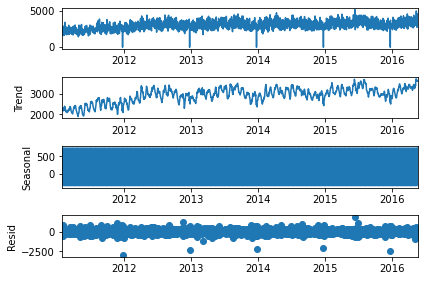

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the sales data from the full time period
fullDecompose = seasonal_decompose(totalSales, model = 'additive')
fullDecompose.plot() # plotting the decomposition
pyplot.show()

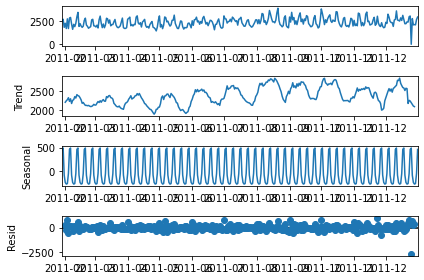

In [11]:
# Decomposing the sales data from 2011
is_2011 = CalendarDF.year == 2011
Calendar2011 = CalendarDF[is_2011] # pull 2011 data from CalendarDF

# Collect total sales data from 2011
Sales2011 = Calendar2011['Food'] + Calendar2011['Hobbies'] + Calendar2011['Household'] 
Sales2011.reset_index(drop = True)
Sales2011.index = Calendar2011['date']

# Decomposition
Decompose2011 = seasonal_decompose(Sales2011, model = 'additive')
Decompose2011.plot()
pyplot.show()

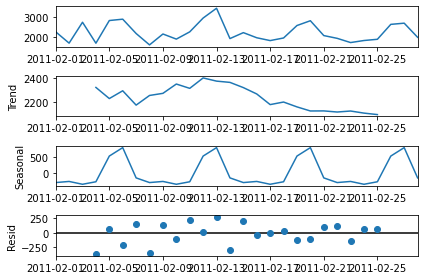

In [12]:
#Decomposing the sales data from February 2011
is_February = Calendar2011.month == 2
February2011 = Calendar2011[is_February] # pull February data from Calendar2011

# Collect total sales data from February 2011
februarySales = February2011['Food'] + February2011['Hobbies'] + February2011['Household']
februarySales.reset_index(drop = True)
februarySales.index = February2011['date']

# Decomposition
februaryDecompose = seasonal_decompose(februarySales, model = 'additive')
februaryDecompose.plot()
pyplot.show()

# **Building the ARIMA Model**

In [13]:
# To build an ARIMA Model, I have to find the 'p', 'q', and 'd' terms. Details found on Selva Prabhakaran's guide

# Begin by checking if the Total Sales time series is stationary using the Augmented Dickey Fuller test

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

statTest = adfuller(totalSales)
print('ADF Statistic: %f' % statTest[0])
print('p-value: %f' % statTest[1])

ADF Statistic: -2.460575
p-value: 0.125364


p-value: 0.000000


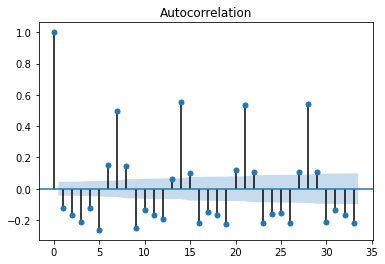

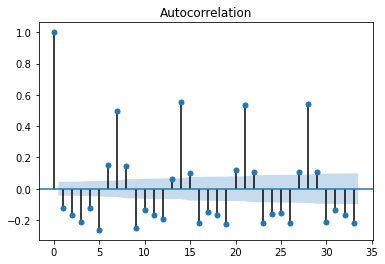

In [14]:
# Since the Total Sales time series does not seem to be stationary (p-value > .05), I perform differencing to find the 'd' and 'q' terms of the ARIMA model

statTest = adfuller(totalSales.diff().dropna())
print('p-value: %f' % statTest[1]) # p-value < .05, set 'd' = 1

# Plot the first differencing to find the 'q' term
plot_acf(totalSales.diff().dropna()) # Since lag 3 is well above the significance region, set 'q' = 3

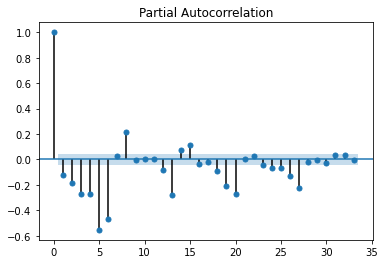

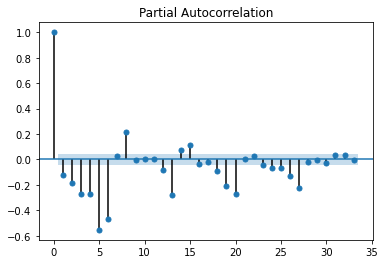

In [15]:
# To find the P term, find the first significant lag by plotting the Partial Autocorrelation of the differenced time series
plot_pacf(totalSales.diff().dropna()) # the first lag is significant, p = 1

In [16]:
# Building the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# Segment the total sales data into Train and Test datasets
salesTrain = totalSales['20110130':'20160410']
salesTest = totalSales['20160411':'20160522']

# Create the model (p,d,q) using p = 1, d =1, q = 3
model = ARIMA(salesTrain.values, order = (1,1,3)) 
model_fit = model.fit(disp = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1897
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -14442.281
Method:                       css-mle   S.D. of innovations            489.602
Date:                Sun, 07 Jun 2020   AIC                          28896.563
Time:                        23:41:46   BIC                          28929.851
Sample:                             1   HQIC                         28908.818
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5566      0.373      1.493      0.135      -0.174       1.287
ar.L1.D.y     -0.4834      0.063     -7.681      0.000      -0.607      -0.360
ma.L1.D.y      0.0099      0.059      0.169      0.8

Since the MA1 term is not significant, I adjusted q to 2 to improve the MA1 term's significance.

In [17]:
model = ARIMA(salesTrain.values, order = (1,1,2)) 
model_fit = model.fit(disp = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1897
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -14466.532
Method:                       css-mle   S.D. of innovations            495.911
Date:                Sun, 07 Jun 2020   AIC                          28943.063
Time:                        23:41:47   BIC                          28970.803
Sample:                             1   HQIC                         28953.276
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5576      0.379      1.472      0.141      -0.185       1.300
ar.L1.D.y      0.1641      0.041      4.007      0.000       0.084       0.244
ma.L1.D.y     -0.6807      0.037    -18.647      0.0

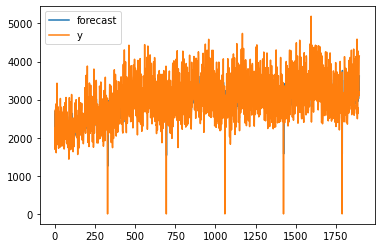

In [18]:
# Actual vs Fitted
model_fit.plot_predict(dynamic = False)
plt.show()

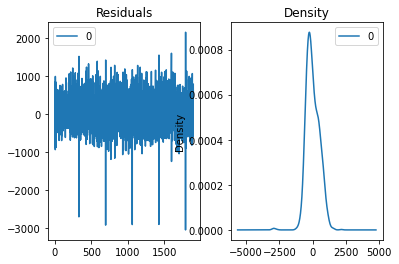

In [19]:
# Plotting the residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

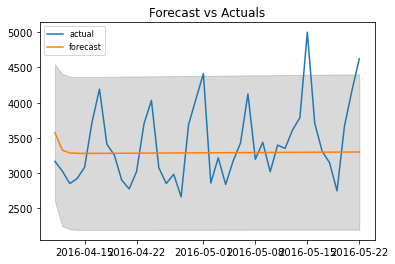

In [20]:
# Using the model to forecast
fitted = model.fit(disp=-1)
fc, se, conf = fitted.forecast(42, alpha = .05) # predicting the total sales of the next 42 days

# Make each forecast value as a pandas Series to plot confidence interval
fc_series = pd.Series(fc, index = salesTest.index)
lower_series = pd.Series(conf[:,0], index = salesTest.index)
upper_series = pd.Series(conf[:,1], index = salesTest.index)

# To improve visualization, I only plot the salesTest data against the forecasted values
plt.plot(salesTest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The forecasted values appear to be a straight line, making the simple ARIMA model an ineffective model in forecasting future sales values. However, the salesTest data lies within the 95% confidence interval of the forecast. Thus, the ARIMA model, while unable to predict exact future sales values, is able to accurately map the linear trend of the data. In order to account for the seasonality present in the sales data, I will build a SARIMA model and measure its effectiveness.

In [21]:
# I use the Pyramid Arima package to perform an auto-SARIMA forecast
!pip install pmdarima
import pmdarima as pm

# We set the seasonality ('m') to 7 in order to account for the weekly seasonality present in the data
smodel = pm.auto_arima(salesTrain, start_p = 1, start_q = 1, test = 'adf',
                      max_p = 3, max_q = 3, m = 7,
                      start_P = 0, seasonal = True, d = None, D = 1,
                      trace = True, error_action = 'ignore', suppress_warnings = True,
                      stepwise = True)

smodel.summary()

     |████████████████████████████████| 1.5 MB 4.7 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=27316.270, BIC=27343.994, Time=5.702 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=28593.482, BIC=28604.571, Time=0.100 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=28072.936, BIC=28095.115, Time=1.859 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=27551.731, BIC=27573.910, Time=2.851 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=28591.666, BIC=28597.211, Time=0.049 seconds
Fit ARIMA(1,0,1)x(0,1,0,7) [intercept=True]; AIC=28473.064, BIC=28495.243, Time=0.741 seconds
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=27318.256, BIC=27351.525, Time=6.427 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1898
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -13653.135
Date:                           Sun, 07 Jun 2020   AIC                          27316.270
Time:                                   23:43:19   BIC                          27343.994
Sample:                                        0   HQIC                         27326.479
                                          - 1898                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4007      0.143      2.793      0.005       0.120       0.682
ar.L1          0.8902      0.020     45.296      0.000       0.852       0.929
ma.L1         -0.6475      0.028    -23.196      0.000      -0.702      -0.593
ma.S.L7       -0.9576      0.008   -119.938      0.000      -0.973      -0.942
sigma2      1.083e+05   1300.657     83.266      0.000    1.06e+05    1.11e+05
===================================================================================
Ljung-Box (Q):                      231.21   Jarque-Bera (JB):             20696.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -1.33
Prob(H) (two-sided):                  0.54   Kurtosis:                        18.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# Forecasting using the SARIMA model
n_periods = 42 # forecasting the next 42 days of sales
fitted, confint = smodel.predict(n_periods = n_periods, return_conf_int = True)
index_of_fc = pd.date_range(salesTest.index[0], periods = n_periods, freq = 'D') # setting freq = 'D' for daily indexing

# Making series for plotting purposes
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

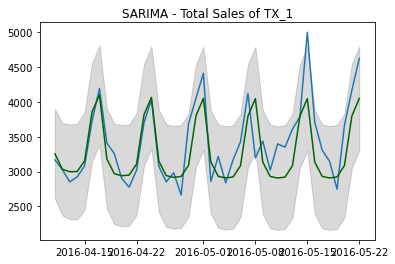

In [23]:
# Plotting the salesTest data against the forecasted values
plt.plot(salesTest)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Total Sales of TX_1")
plt.show()

The SARIMA model is able to more accuractely predict the fluctuations in total sales values. 

I will now write the sMAPE and MASE functions to evaluate the accuracy of the models.

In [24]:
#Accuracy metrics
def symmetric_mean_absolute_percentage_error(actual,forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual)/(np.abs(actual)+np.abs(forecast)))

def mean_absolute_error(actual, forecast):
    return np.mean(np.abs(actual - forecast))

def naive_forecasting(actual, seasonality):
    return actual[:-seasonality]

def mean_absolute_scaled_error(actual, forecast, seasonality):
    return mean_absolute_error(actual, forecast) / mean_absolute_error(actual[seasonality:], naive_forecasting(actual, seasonality))

In [25]:
# Using SMAPE to evaluate the ARIMA model
symmetric_mean_absolute_percentage_error(salesTest['Sales'], fc)

0.125093591150646

In [26]:
# Using MASE to evaluate the SARIMA model
mean_absolute_scaled_error(salesTest.values, fitted, seasonality = 7) # set seasonality to 7 to account for weekly seasonality

1.5767009388665603